In [11]:
import torch
import clip
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import seaborn as sns
from scipy.spatial.distance import euclidean, pdist, squareform

import os
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [12]:
# stimuli can be downloaded here: https://osf.io/cvrb2/

subfolders = [f.path for f in os.scandir("./RESPACT_Stimuli_resized") if f.is_dir()]
activity_names = [f.split("/")[-1] for f in subfolders]

In [24]:
i = 0

cos = torch.nn.CosineSimilarity()

activity_to_vec = {}

for subfolder in subfolders:
    
    # For simplicity, only look one actor for now...
    for actor in ("actor_2",):
        activity_images = glob(subfolder + "/" + actor + "/*")
        
        # .. and one image
        for image_file in activity_images[1:2]:
            #print("Image: ", image_file)
            image = preprocess(Image.open(image_file)).unsqueeze(0).to(device)
            activity_name = image_file.split("/")[2]
            
            with torch.no_grad():
                image_features = model.encode_image(image)
                activity_to_vec[activity_name] = image_features
                

<AxesSubplot:>

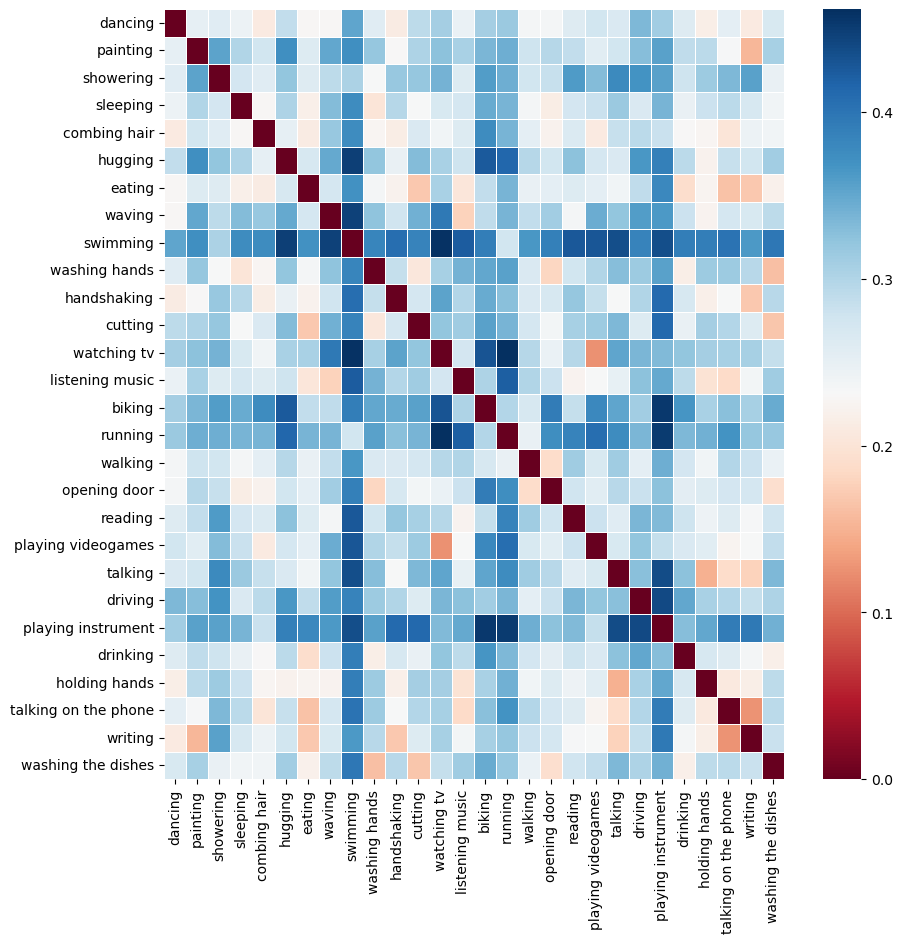

In [25]:
similarity = {}


matrix = []
for activity1 in activity_to_vec.keys():
    to_append = []
    for activity2 in activity_to_vec.keys():        
        cos_sim = cos(activity_to_vec[activity1], activity_to_vec[activity2]).item()
        to_append.append(1 - cos_sim) # subtract from one to get dissimilarity
        similarity[(activity1, activity2)] = cos_sim
    matrix.append(to_append)
        
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, xticklabels=activity_to_vec.keys(), yticklabels=activity_to_vec.keys(), cmap='RdBu', linewidths=.5, ax=ax)

In [15]:
# Ordered according to the paper by Tucciarelli et al
activities_ordered =  ["driving", "walking", "running", "biking", "swimming", "dancing", "waving", "handshaking", "hugging", "holding hands", "talking on the phone", "talking", "painting", "writing", "reading", "listening music", "playing instrument", "playing videogames", "watching tv", "sleeping", "combing hair", "showering", "washing hands", "washing the dishes", "cutting", "eating", "drinking", "opening door"]

<AxesSubplot:>

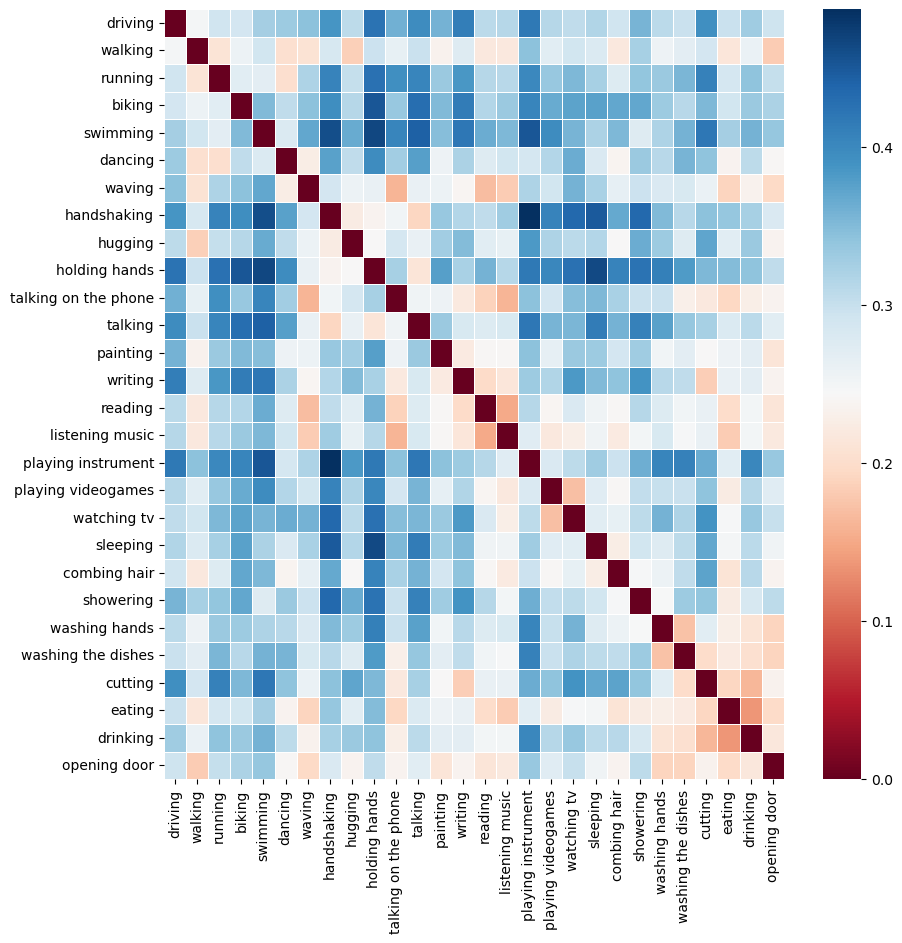

In [16]:
matrix = []
for activity1 in activities_ordered:
    to_append = []
    for activity2 in activities_ordered:        
        cos_sim = cos(activity_to_vec[activity1], activity_to_vec[activity2]).item()
        to_append.append(1 - cos_sim) # subtract from one to get dissimilarity
    matrix.append(to_append)
        
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, xticklabels=activities_ordered, yticklabels=activities_ordered, cmap='RdBu', linewidths=.5, ax=ax)

<AxesSubplot:>

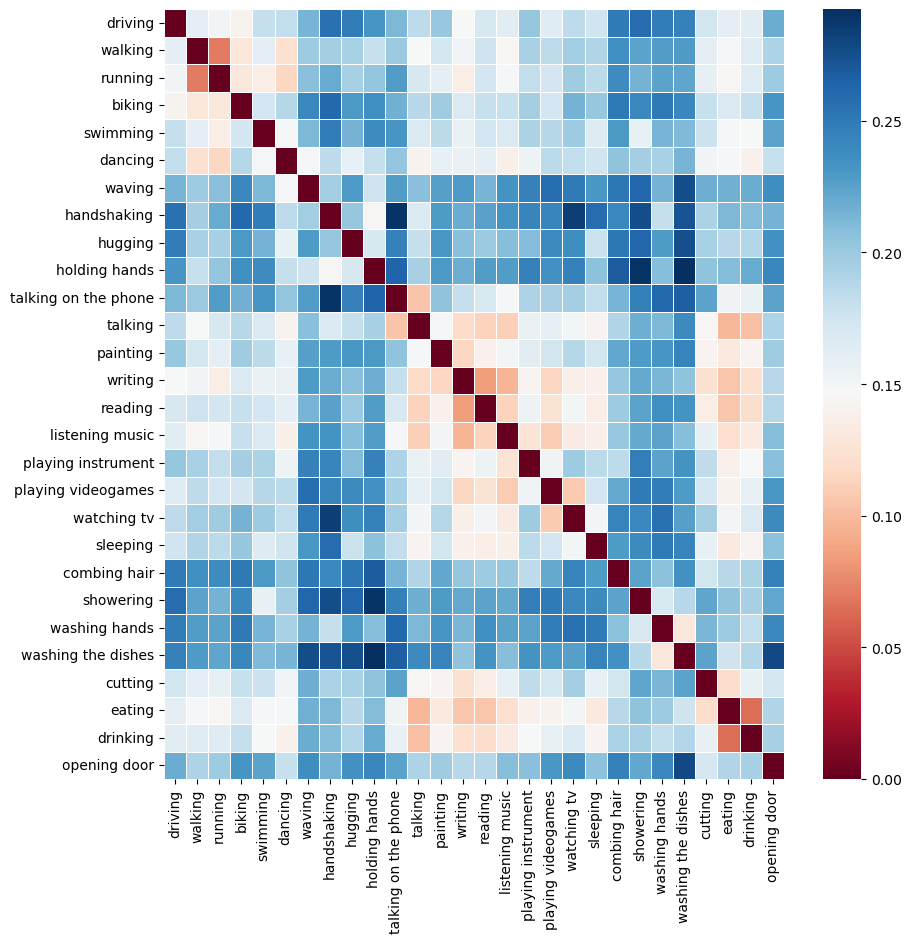

In [20]:
# Text features


matrix = []

with torch.no_grad():
    for activity1 in activities_ordered:
        to_append = []
        for activity2 in activities_ordered:        
            cos_sim = cos(model.encode_text(clip.tokenize(activity1)), model.encode_text(clip.tokenize(activity2))).item()
            to_append.append(1 - cos_sim) # subtract from one to get dissimilarity
        matrix.append(to_append)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, xticklabels=activities_ordered, yticklabels=activities_ordered, cmap='RdBu', linewidths=.5, ax=ax)